In [28]:
import pandas as pd 
import numpy as np
import xgboost as xgb 
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

In [29]:
def preProcess():
    path = 'data/'
    df = pd.read_csv(path + 'data.csv')
    df.drop(['Id'], axis = 1, inplace = True)
    return df

In [30]:
data = preProcess()
continuous_feature = ['I'] * 13
continuous_feature = [col + str(i + 1) for i, col in enumerate(continuous_feature)] 
category_feature = ['C'] * 26
category_feature = [col + str(i + 1) for i, col in enumerate(category_feature)] 

In [31]:
for col in category_feature:
    onehot_feats = pd.get_dummies(data[col], prefix = col)
    data.drop([col], axis = 1, inplace = True)
    data = pd.concat([data, onehot_feats], axis = 1)

In [34]:
# train test splitting
x_train, x_val, y_train, y_val = train_test_split(data.drop('Label',axis=1), data.Label, test_size = 0.2, random_state = 2020)
train_matrix = xgb.DMatrix(x_train,y_train, missing = np.NAN)  
valid_matrix = xgb.DMatrix(x_val,y_val, missing = np.NAN)

In [80]:
params = {}
params['objective'] = 'binary:logistic'  # output probabilities
params['eval_metric'] = 'auc'
params["num_rounds"] = 100
params["early_stopping_rounds"] = 30
params['max_depth'] = 6
params['eta'] = 0.1
params["subsample"] = 0.8
params["colsample_bytree"] = 0.8

model = xgb.train(params,train_matrix)

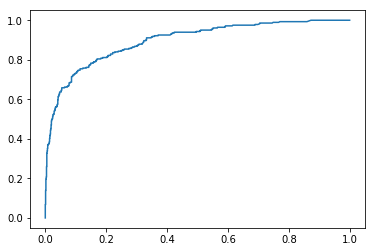

In [89]:
ytest_predict = model.predict(train_matrix)
fpr, tpr, thresholds = metrics.roc_curve(y_train, ytest_predict, pos_label=1)
plt.plot(fpr, tpr)

In [87]:
metrics.auc(fpr, tpr)

0.8960946804641311

In [122]:
lr = LogisticRegression()
lr.fit(x_train.fillna(-1), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

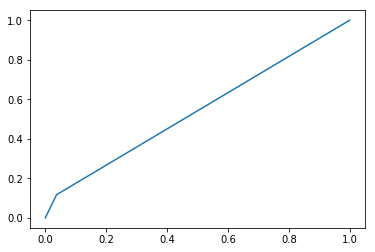

In [100]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, lr.predict(x_train.fillna(-1)))
plt.plot(fpr, tpr)

In [101]:
metrics.auc(fpr, tpr)

0.5401817870616679

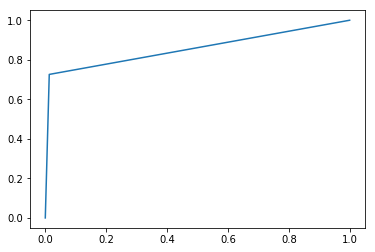

In [120]:
gbdt_feats = model.predict(train_matrix, pred_leaf = True)
gbdt_feats_name = ['gbdt_leaf_' + str(i) for i in range(10)]
df_train = pd.DataFrame(gbdt_feats, columns = gbdt_feats_name) 
train_len = df_train.shape[0]

# one-hot
for col in gbdt_feats_name:
    onehot_feats = pd.get_dummies(df_train[col], prefix = col)
    df_train.drop([col], axis = 1, inplace = True)
    df_train = pd.concat([df_train, onehot_feats], axis = 1)
    
lr = LogisticRegression()
lr.fit(df_train, y_train)
fpr, tpr, thresholds = metrics.roc_curve(y_train, lr.predict(df_train))
plt.plot(fpr, tpr)

In [121]:
metrics.auc(fpr, tpr)

0.8564762977913122

In [148]:
import tensorflow as tf
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
K = tf.keras.backend

class MyLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim=30, **kwargs):
        self.input_dim = input_dim
        self.output_dim = output_dim
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.input_dim, self.output_dim),
                                      initializer='glorot_uniform',
                                      trainable=True)
        super(MyLayer, self).build(input_shape)

    def call(self, x):
        a = K.pow(K.dot(x,self.kernel), 2)
        b = K.dot(K.pow(x, 2), K.pow(self.kernel, 2))
        return K.mean(a-b, 1, keepdims=True)*0.5

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)


def mdl(feature_dim):
    inputs = tf.keras.Input((feature_dim,))
    liner = tf.keras.layers.Dense(units=1, 
                                  bias_regularizer=tf.keras.regularizers.l2(1),
                                  kernel_regularizer=tf.keras.regularizers.l1(2),
                                  )(inputs)
    cross = MyLayer(feature_dim)(inputs)
    add = tf.keras.layers.Add()([liner, cross])
    predictions = tf.keras.layers.Activation('sigmoid')(add)
    model = tf.keras.Model(inputs=inputs, outputs=predictions)
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.optimizers.Adam(0.0001),
                  metrics=['binary_accuracy'])
    return model


In [150]:
model = mdl(x_train.shape[1])
model.fit(x_train.fillna(-1), y_train, epochs=20, batch_size=16)

Epoch 1/20
80/80 [==============================] - 0s 2ms/step - loss: 201.0177 - binary_accuracy: 0.7263
Epoch 2/20
80/80 [==============================] - 0s 2ms/step - loss: 71.8254 - binary_accuracy: 0.7623
Epoch 3/20
80/80 [==============================] - 0s 2ms/step - loss: 11.6579 - binary_accuracy: 0.7592
Epoch 4/20
80/80 [==============================] - 0s 2ms/step - loss: 2.4334 - binary_accuracy: 0.7709
Epoch 5/20
80/80 [==============================] - 0s 2ms/step - loss: 3.2836 - binary_accuracy: 0.8014
Epoch 6/20
80/80 [==============================] - 0s 2ms/step - loss: 2.8018 - binary_accuracy: 0.7952
Epoch 7/20
80/80 [==============================] - 0s 2ms/step - loss: 2.3951 - binary_accuracy: 0.8413
Epoch 8/20
80/80 [==============================] - 0s 2ms/step - loss: 2.6739 - binary_accuracy: 0.8647
Epoch 9/20
80/80 [==============================] - 0s 2ms/step - loss: 1.6492 - binary_accuracy: 0.8616
Epoch 10/20
80/80 [==============================] 

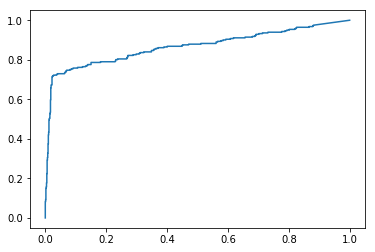

In [153]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, model.predict(x_train.fillna(-1)))
plt.plot(fpr, tpr)